# Milestone 3

In this notebook, we want to finish answer our research questions and produce the data for the data story. The goals are the following: 
- Quantify world peace at different scales (global, region, country)
- Classify actors
- try to look into media coverage

We use two approaches to 'tell' the data, the approach by country and the approach by actor.

Eventually we extract important data about conflicts responsible for most of the death toll for each year. More is explained in the last part of this notebook.

#### Country approach: 

For each country we want to produce a CSV summarizing as many things as possible:
- civilian deaths time series
- total deaths time series
- GBP time series

#### Data on conflicts for each region
In this part of the notebook, we export the data necessary to visualize and interpret the time series of total death for each region. We first want the time series but we also want to be able to explain the outliers, that is the particularly high bars by looking at what conflit contributed majorly to the dead toll of the current bar.


#### Actor approach:

As announced in milestone 2, we would like to be able to classify actors according to their goal for example, their philosophy etc...

It's interresting to note that we have enriched our data set using an addition UCDP data set that lists all the full names of actors and not only their acronyms.

We procede in two steps:
- first we categorize as many actors as possible by looking for keywords in their names (s.t. `Islamic`, `Cartel`, `Government`)
- then we scrap some key wikipedia pages in order to retrieve information on international armged groups. This part is explained in the notebook `wikipedia_scraping` available [here](https://nbviewer.jupyter.org/github/armand33/applied_data_analysis_2017/blob/master/project/notebooks/wikipedia_scraping.ipynb).
- eventually we try to match those scraped armed groups with those involved in the events in our data set in order to be able to filter events by nature (for example terrorist attacks, left-wing uprisals ...). This matching is done using the Levenstein string distance.

The pages we scrap are:
- [List of left-wing rebel groups](https://en.wikipedia.org/wiki/List_of_left-wing_rebel_groups)
- [List of designated terrorist groups](https://en.wikipedia.org/wiki/List_of_designated_terrorist_groups)
- [List of active revel groups](https://en.wikipedia.org/wiki/List_of_active_rebel_groups)
- [List of guerilla movements](https://en.wikipedia.org/wiki/List_of_guerrilla_movements)

#### Media Coverage Analysis
In this part of the notebook, we try to answer one of our research questions about the media coverage of events. We want to try and find out if this coverage is biased regarding the regions.

In [1]:
import pandas as pd 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
df = pd.read_csv('../data/ged171.csv')
print(df.shape)

(135181, 42)


#### Data Cleaning (like in milestone 2)

Let's get a list of all the actors involved on `side_a` or `side_b` in all events since 1989.

In [4]:
actors = {}
for i in df.index:
    tmp_id = df.loc[i, 'side_a_new_id']
    if tmp_id in actors.keys():
        actors[tmp_id].add(df.loc[i, 'side_a'])
    if tmp_id not in actors.keys():
        actors[tmp_id] = set()
        actors[tmp_id].add(df.loc[i, 'side_a'])
    tmp_id = df.loc[i, 'side_b_new_id']
    if tmp_id in actors.keys():
        actors[tmp_id].add(df.loc[i, 'side_b'])
    if tmp_id not in actors.keys():
        actors[tmp_id] = set()
        actors[tmp_id].add(df.loc[i, 'side_b'])

`actors` is a dictionary of having as keys `sides_id`s and values the `sides_name`s. 

**Need for cleaning:**
We notice that some sides have more than one actor, such as `High Council of Afghanistan Islamic Emirate, IS`. Both the HCAIE and IS were involved side by side in this event. We want to clean this. In order to do so, we will modify the initial DataFrame `df` fields `side_a`, `side_b`, `side_a_new_id` and `side_b_new_id` and turn those into lists. We now want ids to refer to single actors.

In [5]:
for k in actors.keys():
    n = actors[k].pop()
    n = n.split(',')
    if n[0] == 'Military faction (forces of Honasan': # this is the only case where the split function 
                                                      # gives something inconsistent
        n = [n[0]+n[1]]
    for i in range(len(n)):
        if n[i][0] == ' ':
            n[i] = n[i][1:]
        if n[i][-1] == '':
            n[i] = n[i][:-1]
    actors[k] = n

In [6]:
# this function goes through the dictionary to return the id of the actor.
def find_id(actor):
    for i in actors.keys():
        if actor in actors[i]:
            return i

In [7]:
initial_keys = list(actors.keys())
for k in initial_keys:
    if len(actors[k]) > 1:
        for i in range(len(actors[k])):
            if [actors[k][i]] in actors.values():
                idd = find_id(actors[k][i])
                actors[k][i] = idd
            else:
                # this actor is not in the dictionary yet (it has not been involved on his own in a event)
                # let's create a new id and insert it in the dictionary
                act = actors[k][i]
                actors[k][i] = np.amax(list(actors.keys()))+1 # this is the new id
                actors[np.amax(list(actors.keys()))+1] = [act] # the actor is inserted

Now let's complete the dataframe `df`. `side_a` and `side_b` to be a list of names and `side_a_new_id` and `side_b_new_id` to be a list of ids of actors.

In [8]:
# We need to turn column types ito objects in order to insert lists
df.side_a_new_id = df.side_a_new_id.astype(object)
df.side_b_new_id = df.side_b_new_id.astype(object)

In [9]:
for i in df.index:
    ida = int(df.at[i, 'side_a_new_id'])
    idb = int(df.at[i, 'side_b_new_id'])
    
    if len(actors[ida]) == 1: 
        df.at[i, 'side_a_new_id'] = [ida]
    else:
        df.at[i, 'side_a_new_id'] = [t for t in actors[ida]]
        
    if len(actors[idb]) == 1: 
        df.at[i, 'side_b_new_id'] = [idb]
    else:
        df.at[i, 'side_b_new_id'] = [t for t in actors[idb]]
    
    df.at[i, 'side_a'] = np.array([actors[k][0] for k in df.at[i, 'side_a_new_id']])
    df.at[i, 'side_b'] = np.array([actors[k][0] for k in df.at[i, 'side_b_new_id']])

Now we can remove the ids that corresponded to multiple actors.

In [10]:
def remove_multiples(d):
    r = dict(d)
    for k in d.keys():
        if len(d[k]) > 1:
            del(r[k])
    return r

actors = remove_multiples(actors)

The following example shows how we have parsed `side_a` and `side_b` to extract the three governments involved in the event on `side_a`.

In [11]:
df.loc[df.index >= 70444, ['conflict_name', 'dyad_name', 'side_a_new_id', 'side_b_new_id', 'side_a', 'side_b']].head(1)

,conflict_name,dyad_name,side_a_new_id,side_b_new_id,side_a,side_b
70444,"Governments of Australia, United Kingdom, Unit...","Government of Australia, Government of United ...","[6740, 28, 3]",[116],"[Government of Australia, Government of United...",[Government of Iraq]


# Data on the countries

In this part of the notebook, we want to produce data files that will be visualized in de data story.

These are the countries for which there is no recorded event. However according to the description appart for North Korea and Syria, it seems that it is because no event occured. We cannot assume the data set is perfect but we will however take the values for such countries (excluding North-Korea and Syria) as equal to 0 event, deaths...

In [12]:
additionals = ['Antarctica', 'French Southern and Antarctic Lands', 'Australia', 'Austria', 'Benin', 'Bulgaria', 
               'The Bahamas', 'Belarus', 'Belize', 'Brunei', 'Switzerland', 'Chile', 'Costa Rica', 'Cuba', 
               'Northern Cyprus', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'Estonia', 
               'Finland', 'Fiji', 'Falkland Islands', 'Gabon', 'Gambia', 'Equatorial Guinea', 'Greece', 
               'Greenland', 'Hungary', 'Ireland', 'Iceland', 'Japan', 'Kazakhstan', 'South Korea', 'Kosovo', 
               'Lithuania', 'Luxembourg', 'Latvia', 'Montenegro', 'Mongolia', 'Malawi', 'New Caledonia', 'Norway', 
               'New Zealand', 'Oman', 'Poland', 'Puerto Rico', 'North Korea', 'Portugal', 'Western Sahara', 
               'Somaliland', 'Suriname', 'Slovakia', 'Slovenia', 'Sweden', 'Syria', 
               'Turkmenistan', 'East Timor', 'Taiwan', 'Uruguay', 'Vietnam', 'Vanuatu', 'West Bank']

Let's have a look at the civilian deaths count aggregated over all the years for each country.

In [13]:
death_counts = pd.DataFrame(df.groupby('country').sum()[['best', 'deaths_civilians']])
death_counts.columns = ['total', 'civilians']
death_counts.to_csv('../data/story/death_counts.csv', sep=';')

In [14]:
countries = set(df.drop_duplicates('country')['country'])

Using an additional data set provided by the [World Bank](https://data.worldbank.org/), we look at the Growth Domestic Product time series for each country. This will be used in order to try to find correlations between war and underdeveloppement.

In [15]:
d = {}
d["Cote d'Ivoire"] = 'Ivory Coast'
d['Congo, Dem. Rep.'] = 'DR Congo (Zaire)'
d['Yemen, Rep.'] = 'Yemen (North Yemen)'
d['Serbia'] = 'Serbia (Yugoslavia)'
d['Romania'] = 'Rumania'
d['Iran, Islamic Rep.'] = 'Iran'
d['Kyrgyz Republic'] = 'Kyrgyzstan'
d['Myanmar'] = 'Myanmar (Burma)'
d['Bosnia and Herzegovina'] = 'Bosnia-Herzegovina'
d['Lao PDR'] = 'Laos'
d['Russian Federation'] = 'Russia (Soviet Union)'
d['Egypt, Arab Rep.'] = 'Egypt'
d['Congo, Rep.'] = 'Congo'
d['Cambodia'] = 'Cambodia (Kampuchea)'
d['Madagascar'] = 'Madagascar (Malagasy)'
d['Venezuela, RB'] = 'Venezuela'
d['United States'] = 'United States of America'
d['Zimbabwe'] = 'Zimbabwe (Rhodesia)'
d['Bahamas, The'] = 'The Bahamas'
d['Brunei Darussalam'] = 'Brunei'
d['Gambia, The'] = 'Gambia'
d['Korea, Rep.'] = 'South Korea'
d['Korea, Dem. People’s Rep.'] = 'North Korea'
d['Syrian Arab Republic'] = 'Syria'
d['Timor-Leste'] = 'East Timor'
d['West Bank and Gaza'] = 'West Bank'

In [16]:
gdp = pd.read_csv('../data/gdp_worldbank.csv')

for i in gdp.index:
    if gdp.loc[i, 'Country Name'] in d.keys():
        gdp.loc[i, 'Country Name'] = d[gdp.loc[i, 'Country Name']]
        

gdp.drop(['Indicator Name'], axis = 1, inplace=True)
gdp.drop(['Country Code'], axis = 1, inplace=True)
gdp.drop(['Indicator Code'], axis = 1, inplace=True)
gdp.drop(['Unnamed: 62'], axis = 1, inplace=True)
gdp.drop(['2017'], axis = 1, inplace=True)

for i in range(1960, 1989):
    gdp.drop([str(i)], axis = 1, inplace=True)

gdp.set_index('Country Name', inplace=True)
gdp.fillna(value=0, inplace=True)

gdp = gdp.loc[list(countries) + additionals]

In [17]:
year_country = df.groupby(['country', 'year'])['deaths_civilians'].sum()
civilians = pd.DataFrame(year_country)

year_country = df.groupby(['country', 'year'])['best'].sum()
total = pd.DataFrame(year_country)

df['event'] = 1
events = pd.DataFrame(df.groupby(['country', 'year'])['event'].sum())

for c in countries:
    tmp = pd.DataFrame(columns=['total', 'civilians', 'events', 'gdp'])
    tmp.index.name = 'year'
    for i in range(1989, 2017):
        tmp.loc[i] = [0,0,0,0]
    
    for i in civilians.loc[c].index:
        tmp.loc[i, 'civilians'] = civilians.loc[c].loc[i, 'deaths_civilians']
        
    
    for i in total.loc[c].index:
        tmp.loc[i, 'total'] = total.loc[c].loc[i, 'best']
    
    for i in events.loc[c].index:
        tmp.loc[i, 'events'] = events.loc[c].loc[i, 'event']
        
    tmp['gdp'] = gdp.loc[c].values
        
    tmp.to_csv('../data/story/countries/{}.csv'.format(c))

In [18]:
for c in additionals:
    tmp = pd.DataFrame(columns=['total', 'civilians', 'events', 'gdp'])
    tmp.index.name = 'year'
    for i in range(1989, 2017):
        tmp.loc[i] = [0,0,0,0]
    
    gdp.loc[c]
    tmp['gdp'] = gdp.loc[c].values
    tmp.fillna(value = 0, inplace=True)
    tmp.to_csv('../data/story/countries/{}.csv'.format(c))

Eventually we concatenate all the data and export it in a csv. It's ready for visualization in the data story.

# Actors classification

In this part of the notebook we want to produce statistics on the actors. 

- The same data cleaning that was done in milestone 2 about the actors names. We get from this step a dictionnary of actors ids and actors names.
- Data set by using the additional UCDP data set providing full names for actors.
- Actors are classified first by looking for key words in their full names such as `Islamic`, `Cartel`, `Government` for example.
- Then data is enriched by scraping some key Wikipedia pages (`List of designated terrorist groups`, `List of left-wing rebel groups`...) 
- Actors are matched with armed groups from Wikipedia scraping by using a **string distance** (like in hw2).
- For each actor, we compute the number of deaths cause in the ranks of his opponents by going through all the events listed in the data frame and also the total number of civilian deaths he has been involved.
- Eventually we merge all the data we collected in a big data frame that summarize all we know about actors.

This final data frame will be used to visualize our data story.

## 2) Classifying the actors

Actors are classified by looking for specific queries in their names.

In [19]:
act = pd.read_csv('../data/actorlist.csv')
ids = set(actors.keys())

In [20]:
def find_full_name(name):
    """
    This function returns the full name fo an actor by looking into the additional UCDP data set.
    If no full name is found, None is returned.
    """
    for i in act.index:
        if act.loc[i, 'Name'] == name:
            return act.loc[i, 'NameFull']
    return None

In [21]:
def find_name(full_name):
    """
    This function returns the name fo an actor by looking into the additional UCDP data set.
    If no name is found, None is returned.
    """
    for i in act.index:
        if act.loc[i, 'NameFull'] == full_name:
            return act.loc[i, 'Name']
    return None

In [22]:
def find_actors(dictionnary, words):
    """
    This function goes through all the actors' names or full names (depending if a full name is provided)
    and add the actors name to the dictionnary (passed in argument) if any of the given words is in 
    the name (or full name).
    """
    for i in ids.copy():
        name = actors[i][0]
        full_name = find_full_name(name)
        
        if full_name is None:
            full_name = name

        for word in words:
            if not pd.isnull(full_name) and (word in full_name.lower()):
                dictionnary[i] = full_name
                break

### Classification by names

We look for some key words in the names of all actors in order to build a classification.

#### Governments

In [23]:
govs = {}

In [24]:
find_actors(govs, ['government'])

In [25]:
print('Number of governments: {}'.format(len(govs)))
print('Remaining actors: {}'.format(len(ids)))

Number of governments: 93
Remaining actors: 1128


#### Liberation movements

In [26]:
liberation_movements = {}

In [27]:
find_actors(liberation_movements, ['liberation', 'salvation'])

In [28]:
print('Number of liberation mouvements: {}'.format(len(liberation_movements)))
print('Remaining actors: {}'.format(len(ids)))

Number of liberation mouvements: 73
Remaining actors: 1128


#### Insurgents

In [29]:
insurgents = {}

In [30]:
find_actors(insurgents, ['insurgents'])

In [31]:
print('Number of insurgents: {}'.format(len(insurgents)))
print('Remaining actors: {}'.format(len(ids)))

Number of insurgents: 4
Remaining actors: 1128


#### Communist revolutionaries

In [32]:
communists = {}

In [33]:
find_actors(communists, ['socialist', 'communist', "people's"])

In [34]:
print('Number of communists: {}'.format(len(communists)))
print('Remaining actors: {}'.format(len(ids)))

Number of communists: 41
Remaining actors: 1128


#### Islamists

In [35]:
islamists = {}

In [36]:
find_actors(islamists, ['islam', 'jihad'])

In [37]:
print('Number of islamists: {}'.format(len(islamists)))
print('Remaining actors: {}'.format(len(ids)))

Number of islamists: 44
Remaining actors: 1128


#### Factions

In [38]:
factions = {}

In [39]:
find_actors(factions, ['faction'])

In [40]:
print('Number of factions: {}'.format(len(factions)))
print('Remaining actors: {}'.format(len(ids)))

Number of factions: 78
Remaining actors: 1128


#### Cartels

In [41]:
cartels = {}

In [42]:
find_actors(cartels, ['cartel'])

In [43]:
print('Number of cartels: {}'.format(len(cartels)))
print('Remaining actors: {}'.format(len(ids)))

Number of cartels: 22
Remaining actors: 1128


#### Muslims

In [44]:
muslims = {}

In [45]:
find_actors(muslims, ['muslim'])

In [46]:
print('Number of muslims: {}'.format(len(muslims)))
print('Remaining actors: {}'.format(len(ids)))

Number of muslims: 9
Remaining actors: 1128


#### Christians

In [47]:
christians = {}

In [48]:
find_actors(christians, ['christian'])

In [49]:
print('Number of christians: {}'.format(len(christians)))
print('Remaining actors: {}'.format(len(ids)))

Number of christians: 5
Remaining actors: 1128


#### Republics

In [50]:
republics = {}

In [51]:
find_actors(republics, ['republic'])

In [52]:
print('Number of republics: {}'.format(len(republics)))
print('Remaining actors: {}'.format(len(ids)))

Number of republics: 33
Remaining actors: 1128


In [53]:
classes = [govs, liberation_movements, insurgents, communists, islamists, factions, cartels, muslims, christians, republics]

In [54]:
classified = set()
for class_ in classes:
    classified = classified.union(set(class_.values()))

## Scraping Wikipedia

In this part, we load a dataframe that has been generated in the notebook `wikipedia_scraping`. Those are the actors listed on the following pages: 
- [List of left-wing rebel groups](https://en.wikipedia.org/wiki/List_of_left-wing_rebel_groups)
- [List of designated terrorist groups](https://en.wikipedia.org/wiki/List_of_designated_terrorist_groups)
- [List of active revel groups](https://en.wikipedia.org/wiki/List_of_active_rebel_groups)
- [List of guerilla movements](https://en.wikipedia.org/wiki/List_of_guerrilla_movements)


We then try to match the actors we have in the data set with the one that were scraped from Wikipedia.

In [55]:
wiki = pd.read_pickle('../data/wikipedia_scraping.pickle')

In [56]:
all_actors = set()
for ind in actors.keys():
    for i in actors[ind]:
        all_actors.add(i)

In [57]:
all_actor_full_names = set()
for actor in all_actors:
    full_name = find_full_name(actor)
    if full_name is not None:
        all_actor_full_names.add(full_name)
    else:
        all_actor_full_names.add(actor)

In [58]:
wiki_names = set(wiki['name'].values)

We are now trying to match names from the `all_actor_full_names` set to `wiki_names`. Which of our actors have we found on Wikipedia ?

In [59]:
from fuzzywuzzy import process

In [60]:
all_actor_full_names.remove(np.NaN)

In [61]:
matched = {}
almost_matched = {}
pairs = set()
for name in all_actor_full_names:   
    test = process.extractOne(name, wiki_names)
    if test[0] == name:
        matched[name] = name
    if test[0] != name and test[1] > 86:
        almost_matched[name] = test[0]

The following are mismatched that we remove by hand.

In [62]:
del almost_matched['Afrikaner Resistance Movement']
del almost_matched['Amaro']
del almost_matched['Arab']
del almost_matched['Arab Movement of Azawad']
del almost_matched['Ari']
del almost_matched['Armed Islamic Group']
del almost_matched['Armed Islamic Movement']
del almost_matched['Armenian']
del almost_matched['Bari']
del almost_matched['Bru National Liberation Front']
del almost_matched['Dawa']
del almost_matched['Chad National Front']
del almost_matched["Eelam People's Revolutionary Liberation Front"]
del almost_matched['Faith Movement of Arakan']
del almost_matched['Fur']
del almost_matched['Garo National Liberation Army']
del almost_matched['Geri']
del almost_matched['Isatabu Freedom Movement']
del almost_matched['Islamic Movement of Kurdistan']
del almost_matched['Islamic Resistance Movement']
del almost_matched['Issa']
del almost_matched['Khmer People’s National Liberation Front']
del almost_matched['Kurdish Democratic Party of Iraq']
del almost_matched['Lao Resistance Movement']
del almost_matched['Macina Liberation Front']
del almost_matched['March 23 Movement']
del almost_matched['Mayi Mayi']
del almost_matched['Military faction']
del almost_matched['Military faction (Red Berets)']
del almost_matched['Military faction (forces of Amsha Desta and Merid Negusie)']
del almost_matched['Military faction (forces of Andres Rodriguez)']
del almost_matched['Military faction (forces of André Kolingba)']
del almost_matched['Military faction (forces of Godefroid Niyombare)']
del almost_matched['Military faction (forces of Maldoum Bada Abbas)']
del almost_matched['Military faction (forces of Nicolae Ceausescu)']
del almost_matched['Military faction (forces of Shahnawaz Tanay)']
del almost_matched['Military faction (forces of Suret Husseinov)']
del almost_matched['Mohajir National Movement']
del almost_matched['Moro']
del almost_matched['Movement for Justice and Peace']
del almost_matched['Movement for Unity and Jihad in West Africa']
del almost_matched['National Democratic Front for Bodoland -  Ranjan Daimary faction']
del almost_matched['National Front for the Liberation of Haiti']
del almost_matched['National Guard and Mkhedrioni']
del almost_matched['National Islamic Movement']
del almost_matched['Orma']
del almost_matched['Oromo']
del almost_matched['Palestinian National Liberation Movement']
del almost_matched['Pan']
del almost_matched['Pari']
del almost_matched['Patriotic Salvation Movement']
del almost_matched["People's Liberation Front"]
del almost_matched['Popular Movement for the Liberation of Azawad']
del almost_matched['Somali National Movement']
del almost_matched['Somali Patriotic Movement']
del almost_matched['Taleban Movement of Pakistan']
del almost_matched['The Knights Templar']
del almost_matched['The Zetas']
del almost_matched['Tiv']
del almost_matched['Union']
del almost_matched['Uzbek']
del almost_matched['Islamic Group']
del almost_matched['Islamic Party']

Now we are looking for names that can be shortened. For example, we would like to replace `Sinaloa Cartel - Los Memos faction` by `Sinaloa Cartel`. Do to so we look for the names we have that appear in other actors'names. This is done by the interractive cell below that for each match asks if we would like to list the two actors for replacement.

As the following cell needs interaction it is commented and it's result as been stored as a pickle file. 

In [63]:
"""
replacement = {}
for full_name in classified:
    for test in classified:
        if full_name != test and full_name.lower() in test.lower():
            print(full_name + ' //// ' + test)
            inp = input()
            if 'y' in inp.lower():
                name = find_name(full_name)
                test_name = find_name(test)
                if name is None:
                    name = full_name
                if test_name is None:
                    test_name = test   
                replacement[find_id(test_name)] = find_id(name)
                
                
with open('../data/replacement.pickle', 'wb') as fi:
    pickle.dump(replacement, fi)
"""

"\nreplacement = {}\nfor full_name in classified:\n    for test in classified:\n        if full_name != test and full_name.lower() in test.lower():\n            print(full_name + ' //// ' + test)\n            inp = input()\n            if 'y' in inp.lower():\n                name = find_name(full_name)\n                test_name = find_name(test)\n                if name is None:\n                    name = full_name\n                if test_name is None:\n                    test_name = test   \n                replacement[find_id(test_name)] = find_id(name)\n                \n                \nwith open('../data/replacement.pickle', 'wb') as fi:\n    pickle.dump(replacement, fi)\n"

This is the pickle file listing the replacements to do.

In [64]:
with open('../data/replacement.pickle', 'rb') as fi:
    replacement = pickle.load(fi)

Now in the original data frame, we replace the actors'names that we found earlier.

In [65]:
for i in df.index:
    tmp_a = df.loc[i, 'side_a_new_id']
    tmp_b = df.loc[i, 'side_a_new_id']
    for k in range(len(tmp_a)):
        if tmp_a[k] in replacement.keys():
            tmp_a[k] = replacement[tmp_a[k]]
    for k in range(len(tmp_b)):
        if tmp_b[k] in replacement.keys():
            tmp_b[k] = replacement[tmp_b[k]]
    df.at[i, 'side_a_new_id'] = tmp_a
    df.at[i, 'side_b_new_id'] = tmp_b

Now we list the actors ids that we found during the Wikipedia scraping.

In [66]:
wiki_ids = {}

In [67]:
for full_name in matched.keys():
    name = find_name(full_name)
    if name is None:
        name = full_name
    idd = find_id(name)
    if idd is not None:
        wiki_ids[idd] = matched[full_name]


In [68]:
for full_name in almost_matched.keys():
    name = find_name(full_name)
    if name is None:
        name = full_name
    idd = find_id(name)
    if idd is not None:
        wiki_ids[idd] = almost_matched[full_name]


Now we list the actors ids that we found during the classification process (using key-words).

In [69]:
classified_ids = {}

In [70]:
classes_names = ['govs', 'liberation_movements', 'insurgents', 'communists', 'islamists', 'factions', 'cartels', 'muslims', 'christians', 'republics']
for i in range(len(classes)):
    for idd in classes[i].keys():
        if idd in classified_ids.keys():
            classified_ids[idd] = classified_ids[idd] + [classes_names[i]]
        else:
            classified_ids[idd] = [classes[i][idd], classes_names[i]]

In [71]:
len(set(classified_ids.keys()).union(set(wiki_ids.keys())))

442

In total, we managed to get information on 442 actors.

Now we merge all the data in a single unified data frame summarizing all we now about each actor.

In [72]:
final_actors = pd.DataFrame(columns = ['id', 'name', 'countries', 'region', 'designated_terrorist', 'current_terrorist', 'former_terrorist', 'left_wing', 'successful_left', 'failed_left', 'former_left', 'guerilla', 'rebel', 'rebel_with', 'rebel_without']+classes_names)

In [73]:
for idd in wiki_ids.keys():
    if idd in replacement.keys():
        idd = replacement[idd]
    final_actors.loc[len(final_actors)] = [idd] + list(wiki.loc[wiki.name == wiki_ids[idd]].values[0]) + [np.NaN for _ in range(10)]

In [74]:
for idd in classified_ids.keys():
    if idd not in wiki_ids.keys():
        kk = classified_ids[idd][1:]
        tmp = [np.NaN for _ in range(len(classes_names))]
        for k in kk:
            tmp[classes_names.index(k)] = 1
        final_actors.loc[len(final_actors)] = [idd, classified_ids[idd][0]] + [None] + [np.NaN for _ in range(12)] + tmp

In [75]:
final_actors.head()

,id,name,countries,region,designated_terrorist,current_terrorist,former_terrorist,left_wing,successful_left,failed_left,...,govs,liberation_movements,insurgents,communists,islamists,factions,cartels,muslims,christians,republics
0,768,Popular Revolutionary Army,[Mexico],Latin America,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,513,African National Congress,[South Africa],NaN,1,1,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,258,Maoist Communist Party,[Turkey],Middle East,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,771,United Self-Defense Forces of Colombia,NaN,NaN,1,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,982,Catalan Liberation Front,[Spain],NaN,NaN,NaN,NaN,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Stats about each actor's involvement.

In [76]:
final_actors['civilian_deaths'] = 0
final_actors['total_deaths'] = 0

In [77]:
def get_index_a(idd):
    l = []
    for i in df.index:
        if idd in df.loc[i, 'side_a_new_id']:
            l.append(i)
    return l

def get_index_b(idd):
    l = []
    for i in df.index:
        if  idd in df.loc[i, 'side_b_new_id']:
            l.append(i)
    return l

In [78]:
counter = 0
for i in final_actors.index:
    counter += 1
    if counter % 40 == 0:
        print('{}/{}'.format(counter, len(final_actors)))
    idd = final_actors.loc[i, 'id']
    ind_a = get_index_a(idd)
    ind_b = get_index_b(idd)
    
    tmp_tot = 0
    tmp_civ = 0
    
    for k in ind_a:
        tmp_tot += df.loc[k, 'deaths_b']
        tmp_civ += df.loc[k, 'deaths_civilians']
    for k in ind_b:
        tmp_tot += df.loc[k, 'deaths_a']
        tmp_civ += df.loc[k, 'deaths_civilians']
        
    final_actors.loc[i, 'civilian_deaths'] = tmp_civ
    final_actors.loc[i, 'total_deaths'] = tmp_tot

40/442
80/442
120/442
160/442
200/442
240/442
280/442
320/442
360/442
400/442
440/442


Adding wikipedia links for each actor.

In [79]:
final_actors['url'] = ''

In [80]:
import wikipedia

for i in final_actors.index:
    try: 
        name = final_actors.loc[i, 'name']
        page = wikipedia.page(name)
        final_actors.loc[i, 'url'] = page.url
    except (wikipedia.PageError, wikipedia.DisambiguationError) as e:
        pass

Adding period of activity for each actor.

In [81]:
final_actors['begin'] = np.NaN
final_actors['end'] = np.NaN

In [82]:
counter = 0
for i in final_actors.index:
    counter += 1
    if counter % 40 == 0:
        print('{}/{}'.format(counter, len(final_actors)))
    idd = final_actors.loc[i, 'id']
    ind_a = get_index_a(idd)
    ind_b = get_index_b(idd)
    
    begin = 2017
    end = 1988
    
    for k in ind_a:
        if df.loc[k, 'year'] > end: 
            end = df.loc[k, 'year']
        if df.loc[k, 'year'] < begin:
            begin = df.loc[k, 'year']
    for k in ind_b:
        if df.loc[k, 'year'] > end: 
            end = df.loc[k, 'year']
        if df.loc[k, 'year'] < begin:
            begin = df.loc[k, 'year']
        
    final_actors.loc[i, 'begin'] = begin
    final_actors.loc[i, 'end'] = end

40/442
80/442
120/442
160/442
200/442
240/442
280/442
320/442
360/442
400/442
440/442


In [83]:
final_actors.begin = final_actors.begin.astype(int)
final_actors.end = final_actors.end.astype(int)

In [84]:
final_actors.to_csv('../data/story/actors.csv')

Let's note that during the building of our data story, some minor incoherences were noted (thanks to the visualizations) and we corrected by hand. The code was not corrected as it would have require a huge amount of complexity to be added compared to the fixes needed.

# Region Analysis

In this part of the notebook, we export the data necessary to visualize and interpret the time series of total death for each region. We first want the time series but we also want to be able to explain the outliers, that is the particularly high bars by looking at what conflit contributed majorly to the dead toll of the current bar.

Let's export the time series of total death for each region.

In [85]:
regions = list(df.drop_duplicates('region')['region'])

In [86]:
regions_count = pd.DataFrame(columns = regions)

for i in range(len(regions)):
    regions_count[regions[i]] = df.loc[df.region == regions[i]].groupby('year').sum()['best'].values

regions_count['year'] = range(1989, 2017)
regions_count.to_csv('../data/story/regions_count.csv', sep=';')

In [87]:
regions_count = pd.DataFrame(columns = regions)
tmp = df[~((df.country == 'Rwanda') & (df.year == 1994))]

for i in range(len(regions)):
    regions_count[regions[i]] = tmp.loc[tmp.region == regions[i]].groupby('year').sum()['best'].values

regions_count['year'] = range(1989, 2017)
regions_count.to_csv('../data/story/regions_count_without_rwandan_genocide.csv', sep=';')

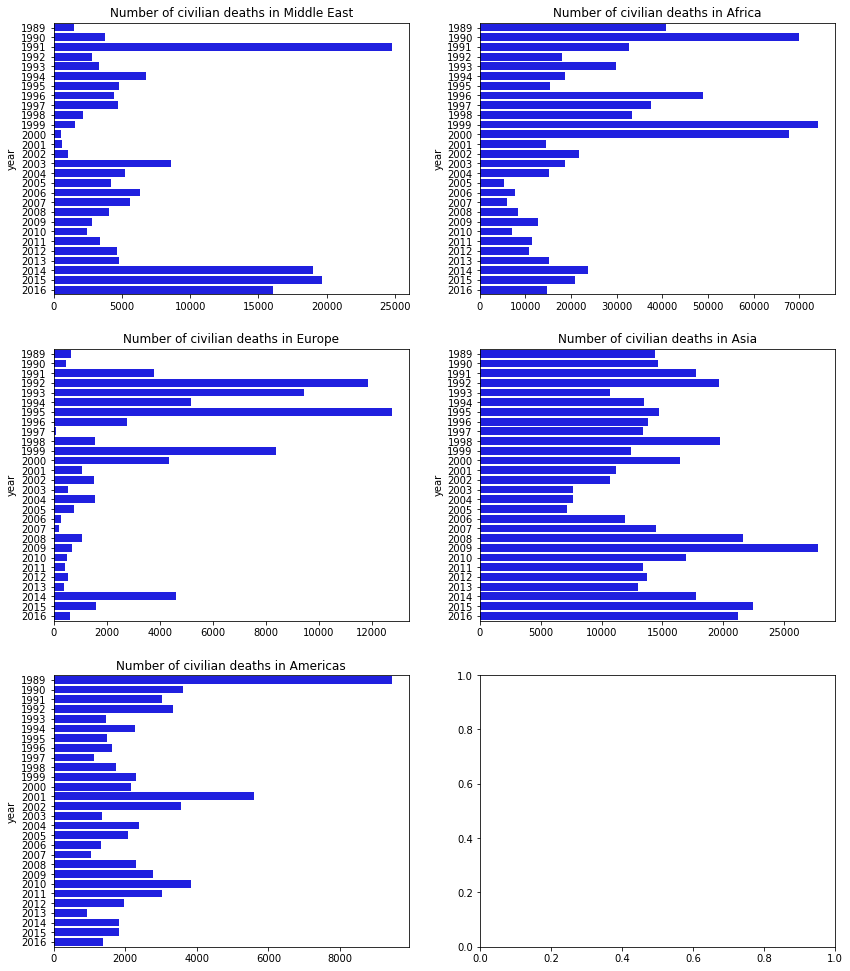

In [88]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14,17))
for i in range(len(regions)):
    aa = df.loc[df.region == regions[i]]
    if i == 1:
        aa = aa.loc[aa.country != 'Rwanda']
    sns.barplot(aa.groupby('year').sum()['best'].values, df.groupby('year').sum()['best'].index, 
                ax=ax[int(i//2), int(i%2)], color='blue', orient = 'h')
    ax[int(i//2), int(i%2)].set_title('Number of civilian deaths in {}'.format(regions[i]))

plt.show()

Now let's produce the data that allows us to interpret the previous bar charts.

For each bar, we want to export the main cause of the bar. We noticed that for most of the bars (that is a death count for a region and a year) there is almost all of the time a conflict that is responsible for most of the count. We want to export this. So we are looking for each region, for a data frame that lists the conflicts responsible for a a major part of the death toll of the year they took place in.

In [89]:
l = []

for i in range(len(regions)):
    region = pd.DataFrame(columns=['year', 'casualties', 'side_a', 'side_b', 'conflict', 'description', 'url'])
    region.side_a.astype(object)
    region.side_b.astype(object)
    
    for y in range(1989, 2017):
        conflicts = df.loc[df.region == regions[i]].loc[df.year == y].groupby('conflict_name').sum()['best']
        conflicts = conflicts.loc[conflicts > conflicts.quantile(0.98)].loc[conflicts > 1000]        
        for ind, conf in enumerate(list(conflicts.index)):
            
            casualties = conflicts.values[ind]
            
            side_a_ids = df.loc[df.region == regions[i]].loc[df.year == y].loc[df.conflict_name == conf, 
                                                                               'side_a_new_id'].values
            side_a_ids = list(side_a_ids)[0]
            
            side_b_ids = df.loc[df.region == regions[i]].loc[df.year == y].loc[df.conflict_name == conf, 
                                                                               'side_b_new_id'].values
            side_b_ids = list(side_b_ids)[0]
            
            side_a = []
            side_b = []
            
            for a in side_a_ids:
                tmp = final_actors.loc[final_actors.id == a, 'name'].values
                if len(tmp) == 0:
                    side_a.append(actors[a][0])
                else:
                    side_a.append(tmp[0])

            for b in side_b_ids:
                tmp = final_actors.loc[final_actors.id == b, 'name'].values
                if len(tmp) == 0:
                    side_b.append(actors[b][0])
                else:
                    side_b.append(tmp[0])
      
            region.loc[len(region)] = [y, casualties, '; '.join(side_a), '; '.join(side_b), conf, 'description', 'url']
    region.to_csv('../data/story/{}.csv'.format(regions[i]))

# Media Coverage Analysis

We would like to measure the media coverage of events as a function of the number of deaths in this event. To do so we comput and indicator $\alpha$ for each event where: $$\alpha_{event} = \frac{number\ of\ sources\ relating\ the\ event}{number\ of\ deaths\ during\ the\ event}$$

In [90]:
tmp = df.loc[df.number_of_sources > 0].loc[df.best > 0]

In [91]:
tmp['indicator'] = tmp.number_of_sources/tmp.best

In [92]:
tmp.groupby('region').mean()['indicator']

region
Africa         0.527613
Americas       0.693560
Asia           0.603988
Europe         0.751326
Middle East    0.418668
Name: indicator, dtype: float64

It seems that Europe has an over coverage and middle east an under coverage.

Let's remove the outliers in order to get a more representative idea of what is going on.

In [93]:
mean_indicator = tmp.best.mean()
std_indicator = tmp.best.std()

In [94]:
tmp = tmp.loc[tmp.best < mean_indicator + std_indicator]

In [95]:
tmp.groupby('region').mean()['indicator']

region
Africa         0.528071
Americas       0.693847
Asia           0.604096
Europe         0.751326
Middle East    0.418668
Name: indicator, dtype: float64

It does not seem to change a lot the results. Let's look at the distribution of the indicator for each region.

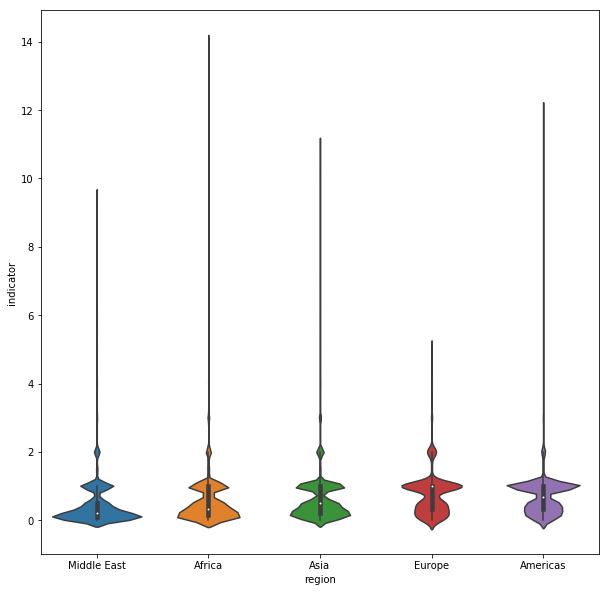

In [96]:
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(data = tmp, y='indicator', x='region', ax=ax)
plt.show()

All the plots have a small waist approximately at the level of the mean. For Middle-East, Africa and Asia, is seems the bottom is bigger than the head and for Europe and Americas it's the inverse. This could be interpreted as a high media coverage for Europe and Americas and a lower for the others. At a number of deaths equal, an event is more likely to get higher coverage in Europe and Americas than in the rest of the world.


This interpretation can seem a little fast however as the set of events are really unbalanced between regions. It seems however really difficult to balance them they are not really comparable in term of frequence and number of casualties. That is why we chose not to include this analysis in our data story.